Xingyu Chen z5187472
Zhan Wai Kam z5076319

---
# Task 1: Efficient d-separation test
---

In [0]:
# https://github.com/lingxuez/bayes-net/blob/master/src/dsep.py
#visualise our graph
from graphviz import Digraph

## Parent Node Finder

Iterates through graph to find parents of an observed node

In [0]:
def find_immediate_parents(G, node):
    parents = []
    for i in G:
        for j in G[i]:
            if j == node:
                parents.append(i)
    return parents
# Debug lines
# e = find_parents(test_graph_letters_1, 'Z')
# print(e)

## D-Separation Determination

In [3]:
import queue
import copy

graph = {
    'BreastDensity': ['Mass'],
    'Mass': ['Size','Shape','Margin'],
    'BC': ['Mass','AD','MC','SkinRetract','Metastasis','NippleDischarge'],
    'Age': ['BC'],
    'Location': ['BC'],
    'Metastasis': ['LymphNodes'],
    'AD': ['FibrTissueDev'],
    'FibrTissueDev': ['Spiculation','SkinRetract','NippleDischarge'],
    'Size': [],
    'Shape': [],
    'Margin': [],
    'MC': [],
    'LymphNodes': [],
    'Spiculation': ['Margin'],
    'NippleDischarge': [],
    'SkinRetract': [],
}
graph

def d_separated(G,X,Y,Z):
    all_leaves = []
    G_copy = copy.deepcopy(G)
    #delete all leaf nodes which aren't included in X U Y U Z
    for node in G:
        if len(G[node]) == 0:
            all_leaves.append(node)
    for leaf in all_leaves:
        if leaf not in X and leaf not in Y and leaf not in Z:
            for node in G:
                if leaf in G[node]:
                    G_copy[node].remove(leaf)
            G_copy.pop(leaf)
    #delete all outgoing edge from nodes in Z
    for node in Z:
        G_copy[node] = []     
    #traverse the graph to find out whether there are avaiable paths or not
    #first traverse all descendents:
    visited = []
    current = queue.Queue()
    for node in X:
        current.put(node)
    while not current.empty():
        curr_node = current.get()
        if curr_node in Y:
            return False
        visited.append(curr_node)
        if curr_node in G_copy:
            for next_layer_node in G_copy[curr_node]:
                current.put(next_layer_node)
    parents = []
    for node in visited:
        parents += find_immediate_parents(G_copy,node)
    for desti in Y:
        if desti in parents:
            return False
    return True

result = d_separated(graph, ['BC'], ['Margin'], ['Mass'])
print(result)
result = d_separated(graph, ['BC'], ['FibrTissueDev'], ['AD'])
print(result)
result = d_separated(graph, ['BC'], ['Margin','FibrTissueDev'], ['Mass','AD'])
print(result)

# dot = Digraph(comment='ICU Graph')
# for v in G_copy:
#     dot.node(str(v))

# for v in G_copy:
#     for w in G_copy[v]:
#         dot.edge(str(v), str(w))
# dot

False
True
True


---
# Task 2: Estimate Bayesian Network parameters from data
---

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks/COMP9418/assignment1/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/COMP9418/assignment1


## Install Necessary Packages

In [0]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# Necessary libraries
import numpy as np
import pandas as pd

# combinatorics
from itertools import product, combinations
# ordered dictionaries are useful for keeping ordered sets of varibles
from collections import OrderedDict as odict
#visualise our graph
from graphviz import Digraph

# table formating for screen output
from tabulate import tabulate

# easier debugging display
pd.set_option('display.multi_sparse', False)
from pprint import pprint

## Plot graph

Only for Visualisation

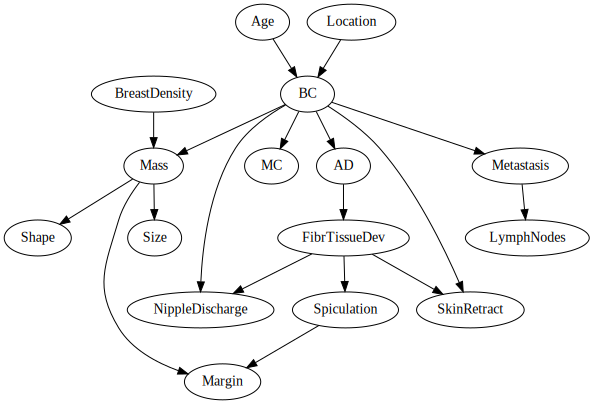

In [6]:
dot = Digraph(comment='ICU Graph')

for v in graph:
    dot.node(str(v))

for v in graph:
    for w in graph[v]:
        dot.edge(str(v), str(w))
dot

## Initial Import for data

In [7]:
import pandas as pd
data = pd.read_csv('bc 2.csv')
print(data.head())

  BreastDensity     Location    Age  ... NippleDischarge Spiculation        Margin
0          high  LolwOutQuad  35-49  ...              No          No  Well-defined
1        medium    UpOutQuad  50-74  ...             Yes          No  Well-defined
2           low     UpInQuad  50-74  ...              No         Yes  Well-defined
3        medium    LowInQuad    >75  ...              No          No   Ill-defined
4          high    LowInQuad    <35  ...              No         Yes   Ill-defined

[5 rows x 16 columns]


## Extract outcomeSpace automatically from data

In [8]:
keys = pd.DataFrame()
outcomeSpace = {}
for elem in data:
    temp = data[elem]
    temp.sort_values()
    temp.drop_duplicates(keep='first', inplace=True)
    temp = temp.reset_index(drop=True)
    # print(temp.index.values.tolist())
    outcomeSpace[elem] = tuple(temp.index.values)
    keys = pd.concat([keys,temp], axis=1)
print(outcomeSpace)

{'BreastDensity': (0, 1, 2), 'Location': (0, 1, 2, 3), 'Age': (0, 1, 2, 3), 'BC': (0, 1, 2), 'Mass': (0, 1, 2), 'AD': (0, 1), 'Metastasis': (0, 1), 'MC': (0, 1), 'Size': (0, 1, 2), 'Shape': (0, 1, 2, 3), 'FibrTissueDev': (0, 1), 'LymphNodes': (0, 1), 'SkinRetract': (0, 1), 'NippleDischarge': (0, 1), 'Spiculation': (0, 1), 'Margin': (0, 1)}


In [9]:
keys

,BreastDensity,Location,Age,BC,Mass,AD,Metastasis,MC,Size,Shape,FibrTissueDev,LymphNodes,SkinRetract,NippleDischarge,Spiculation,Margin
0,high,LolwOutQuad,35-49,No,No,No,no,No,<1cm,Other,No,no,No,No,No,Well-defined
1,medium,UpOutQuad,50-74,Invasive,Benign,Yes,yes,Yes,1-3cm,Oval,Yes,yes,Yes,Yes,Yes,Ill-defined
2,low,UpInQuad,>75,Insitu,Malign,NaN,NaN,NaN,>3cm,Round,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,LowInQuad,<35,NaN,NaN,NaN,NaN,NaN,NaN,Irregular,NaN,NaN,NaN,NaN,NaN,NaN


## Remap data values to integers

In [10]:
remap = {
    'high' : 0,
    'medium' : 1,
    'low' : 2,
    'LolwOutQuad' : 0,
    'UpOutQuad' : 1,
    'UpInQuad' : 2,
    'LowInQuad' : 3,
    '35-49' : 0,
    '50-74' : 1,
    '>75' : 2,
    '<35' : 3,
    'No' : 0,
    'Yes' : 1,
    'Invasive' : 1,
    'Insitu' : 2,
    'Benign' : 1,
    'Malign' : 2,
    '<1cm' : 0,
    '1-3cm' : 1,
    '>3cm' : 2,
    'Other' : 0,
    'Oval' : 1,
    'Round' : 2,
    'Irregular' : 3,
    'no' : 0,
    'yes' : 1,
    'Well-defined' : 0,
    'Ill-defined' : 1,
}
def remapData(file, remap):
    data = pd.read_csv(file)
    for col in data:
        data[col] = data[col].map(remap)
    return data
data = remapData('bc 2.csv', remap)
data

,BreastDensity,Location,Age,BC,Mass,AD,Metastasis,MC,Size,Shape,FibrTissueDev,LymphNodes,SkinRetract,NippleDischarge,Spiculation,Margin
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0
2,2,2,1,1,1,0,1,0,1,0,1,1,1,0,1,0
3,1,3,2,1,2,0,1,1,0,2,0,0,0,0,0,1
4,0,3,3,0,1,0,0,0,2,1,0,0,0,0,1,1
5,1,0,2,0,0,1,0,0,0,0,1,0,1,0,1,1
6,1,1,1,2,0,0,0,0,0,0,1,0,1,0,1,1
7,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1
8,2,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0


## Tutorial Functions

In [0]:
def printFactor(f):
    """
    argument 
    `f`, a factor to print on screen
    """
    # Create a empty list that we will fill in with the probability table entries
    table = list()
    
    # Iterate over all keys and probability values in the table
    for key, item in f['table'].items():
        # Convert the tuple to a list to be able to manipulate it
        k = list(key)
        # Append the probability value to the list with key values
        k.append(item)
        # Append an entire row to the table
        table.append(k)
    # dom is used as table header. We need it converted to list
    dom = list(f['dom'])
    # Append a 'Pr' to indicate the probabity column
    dom.append('Pr')
    print(tabulate(table,headers=dom,tablefmt='orgtbl'))

def allEqualThisIndex(dict_of_arrays, **fixed_vars):
    """
    Helper function to create a boolean index vector into a tabular data structure,
    such that we return True only for rows of the table where, e.g.
    column_a=fixed_vars['column_a'] and column_b=fixed_vars['column_b'].
    
    This is a simple task, but it's not *quite* obvious
    for various obscure technical reasons.
    
    It is perhaps best explained by an example.
    
    >>> all_equal_this_index(
    ...    {'X': [1, 1, 0], Y: [1, 0, 1]},
    ...    X=1,
    ...    Y=1
    ... )
    [True, False, False]
    """
    # base index is a boolean vector, everywhere true
    first_array = dict_of_arrays[list(dict_of_arrays.keys())[0]]
    index = np.ones_like(first_array, dtype=np.bool_)
    for var_name, var_val in fixed_vars.items():
        index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
    return index

def estProbTable(data, var_name, parent_names, outcomeSpace):
    """
    Calculate a dictionary probability table by ML given
    `data`, a dictionary or dataframe of observations
    `var_name`, the column of the data to be used for the conditioned variable and
    `var_outcomes`, a tuple of possible outcomes for the conditiona varible and
    `parent_names`, a tuple of columns to be used for the parents and
    `parent_outcomes` a tuple of all possible parent outcomes 
    Return a dictionary containing an estimated conditional probability table.
    """    
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
    # cartesian product to generate a table of all possible outcomes
    all_parent_combinations = product(*parent_outcomes)

    prob_table = odict()
    for i, parent_combination in enumerate(all_parent_combinations):
        cond_array = []
        # print(parent_names, parent_combination)
        parent_vars = dict(zip(parent_names, parent_combination))
        # print(parent_vars)
        parent_index = allEqualThisIndex(data, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name])==var_outcome)
            prob_table[tuple(list(parent_combination)+[var_outcome])] = (var_index & parent_index).sum()/parent_index.sum()
            
    return {'dom': tuple(list(parent_names)+[var_name]), 'table': prob_table}

## Table Visualisation of each conditional probability

In [12]:
def find_immediate_parents(G, node):
    parents = []
    for i in G:
        for j in G[i]:
            if j == node:
                parents.append(i)
    return parents

for node in graph:
    printFactor(estProbTable(data, node, find_immediate_parents(graph,node), outcomeSpace))
    print()


|   BreastDensity |      Pr |
|-----------------+---------|
|               0 | 0.30145 |
|               1 | 0.4991  |
|               2 | 0.19945 |

|   BreastDensity |   BC |   Mass |        Pr |
|-----------------+------+--------+-----------|
|               0 |    0 |      0 | 0.84992   |
|               0 |    0 |      1 | 0.15008   |
|               0 |    0 |      2 | 0         |
|               0 |    1 |      0 | 0.105152  |
|               0 |    1 |      1 | 0.0966831 |
|               0 |    1 |      2 | 0.798165  |
|               0 |    2 |      0 | 0.200234  |
|               0 |    2 |      1 | 0.407494  |
|               0 |    2 |      2 | 0.392272  |
|               1 |    0 |      0 | 0.892216  |
|               1 |    0 |      1 | 0.107784  |
|               1 |    0 |      2 | 0         |
|               1 |    1 |      0 | 0.205734  |
|               1 |    1 |      1 | 0.163575  |
|               1 |    1 |      2 | 0.630691  |
|               1 |    2 |      0

## Final Function

In [13]:
def learn_bayes_net(G, file, outcomeSpace, prob_tables):
    data = remapData(file,remap)
    for node in graph:
        prob_tables[node] = estProbTable(data, node, find_immediate_parents(graph,node), outcomeSpace)
    return prob_tables
probs_tables = dict.fromkeys(list(graph.keys()))
probs_tables = learn_bayes_net(graph, 'bc 2.csv', outcomeSpace, probs_tables)
probs_tables

{'AD': {'dom': ('BC', 'AD'),
  'table': OrderedDict([((0, 0), 0.9480665648364016),
               ((0, 1), 0.05193343516359836),
               ((1, 0), 0.5471098877831887),
               ((1, 1), 0.45289011221681136),
               ((2, 0), 0.7036645525017619),
               ((2, 1), 0.2963354474982382)])},
 'Age': {'dom': ('Age',),
  'table': OrderedDict([((0,), 0.248),
               ((1,), 0.50025),
               ((2,), 0.1478),
               ((3,), 0.10395)])},
 'BC': {'dom': ('Age', 'Location', 'BC'),
  'table': OrderedDict([((0, 0, 0), 0.7627257799671593),
               ((0, 0, 1), 0.14039408866995073),
               ((0, 0, 2), 0.09688013136288999),
               ((0, 1, 0), 0.5466988727858293),
               ((0, 1, 1), 0.19887278582930756),
               ((0, 1, 2), 0.25442834138486314),
               ((0, 2, 0), 0.6534810126582279),
               ((0, 2, 1), 0.1606012658227848),
               ((0, 2, 2), 0.18591772151898733),
               ((0, 3, 0), 0.6852750

---
# Task 3: Sampling
---

## Topological Sort Function
Sorts graph in topological order. The start node was selected to be 'Location' with 'Age' and 'BreastDensity' manually appended as they are ancestor nodes

In [0]:
def topologicalSort_r(G, v, colour, stack):
    """
    argument 
    G, an adjacency list representation of a graph
    v, current vertex
    colour, colouring dictionary
    stack, list with topological ordering of nodes
    """
    # print('Visiting: ', v)
    # Visited vertices are coloured 'grey'
    colour[v] = 'grey'
    # Let's visit all outgoing edges from v
    for w in G[v]:
        # To avoid loops, we vist check if the next vertex hasn't been visited yet
        if colour[w] == 'white':
            topologicalSort_r(G, w, colour,stack)
    # When we finish the for loop, we know we have visited all nodes from v. It is time to turn it 'black'
    colour[v] = 'black'
    stack.append(v)
    
def topologicalSort(G, start):
    """
    argument 
    G, an adjacency list representation of a graph
    start, starting vertex
    """        
    colour = dict([(node, 'white') for node in G.keys()])
    # We use a stack to store the topological ordering of the nodes, so we can reverse it later
    stack = []
    
    topologicalSort_r(G, start, colour, stack)
    stack.append('BreastDensity')
    stack.append('Age')
    # print('Topological sort: ')
    
    # for node in reversed(stack):
    #     print(node, ' ')
    return stack

In [15]:
topologicalSort(graph, 'Location')

['Size',
 'Shape',
 'Margin',
 'Mass',
 'Spiculation',
 'SkinRetract',
 'NippleDischarge',
 'FibrTissueDev',
 'AD',
 'MC',
 'LymphNodes',
 'Metastasis',
 'BC',
 'Location',
 'BreastDensity',
 'Age']

In [0]:
# This is the main DFS recursive function
def find_parents_r(G, v, colour, parents):
    """
    argument 
    `G`, an adjacency list representation of a graph
    `v`, next vertex to be visited
    `colour`, dictionary with the colour of each node
    """
    # print('Visiting: ', v)
    # Visited vertices are coloured 'grey'
    colour[v] = 'grey'
    # Let's visit all outgoing edges from v
    for w in G:
        # To avoid loops, we vist check if the next vertex hasn't been visited yet
        if colour[w] == 'white' and v in G[w]:
            parents.append(w)
            find_parents_r(G, w, colour, parents)
    # When we finish the for loop, we know we have visited all nodes from v. It is time to turn it 'black'
    colour[v] = 'black'

# This is an auxiliary DFS function to create and initialize the colour dictionary
def find_parents(G, start):
    """
    argument 
    `G`, an adjacency list representation of a graph
    `start`, starting vertex
    """    
    # Create a dictionary with keys as node numbers and values equal to 'white'
    colour = dict([(node, 'white') for node in G.keys()])
    # Call recursive DFS 
    parents = []
    find_parents_r(G, start, colour, parents)
    # We can return colour dictionary. It is useful for some operations, such as detecting connected components
    return parents


## Sampling Functions

In [0]:
import random

def log_cond_anc(curr, prob_node, prob_curr, anc_dict):
    domain = prob_curr['dom']
    input_arr = [None] * (len(domain))
    i = 0
    min = 0
    max = 0
    for parent in domain:
        input_arr[i] = anc_dict[parent]
        i+=1
    input_arr.pop(-1)
    # print(input_arr)
    # print(prob_curr)
    column = np.asarray(list(prob_curr['table'].keys()))
    column = np.delete(column, -1, axis=1)
    # print(column)
    firstInstance = False
    i = 0
    for arg in column:
        arg = list(arg)
        if arg == input_arr and firstInstance == False:
            firstInstance = True
            min = i
        elif arg != input_arr and firstInstance == True:
            max = i
            break
        i+=1
    if i == len(column):
        max = i
    # print(min, max)
    probTable = list(prob_curr['table'].values())
    tot = 0
    # print(probTable[min:max])
    for i in range (min,max):
        if (probTable[i] + tot) > prob_node:
            anc_dict[curr] = i - min
            break
        else:
            tot += probTable[i]
    return anc_dict

def get_all_anc_states(G, node):
    ancestors = find_parents(G, node)
    # print(ancestors)
    order = topologicalSort(graph,'Location')
    # print(order)
    top_parents = []
    i = -1
    while i > -17:
        if order[i] in ancestors:
            top_parents.append(order[i])
        i -= 1
    ancestors.append(node)
    anc_dict = dict.fromkeys(ancestors)
    
    top_parents.append(node)
    # print(top_parents)
    for curr in top_parents:
        # print(curr)
        prob_node = random.uniform(0, 1)
        leaf_node = False
        imm_parents = find_immediate_parents(G, curr)
        prob_curr = probs_tables[curr]
        # Leaf Nodes Case
        if imm_parents == []:
            i = 0
            tot = 0
            for prob_val in prob_curr['table'].values():
                # print(prob_val)
                if (prob_val+tot) > prob_node:
                    # print('tot:',prob_val+tot)
                    anc_dict[curr] = i
                    break
                else:
                    tot += prob_val
                i+=1
            # print(anc_dict)
        else:
            anc_dict = log_cond_anc(curr, prob_node, prob_curr, anc_dict)
        # print(anc_dict)
    prob_node_table = probs_tables[node]
    anc_dict = log_cond_anc(node, prob_node, prob_node_table, anc_dict)
    # print(anc_dict)
    return anc_dict[node]

In [18]:
def generate_samples(n):
    var_list = list(graph.keys())
    entries = ['field', 'probability', 'state']
    samples = []
    for step in range(0, n):
        temp = []
        var_select = random.randint(0,15)
        x_var = var_list[var_select]
        # prob = random.uniform(0, 1)
        temp.append(x_var)
        # temp.append(prob)
        # print(get_all_anc_states(graph, x_var, prob))
        temp.append(get_all_anc_states(graph, x_var))
        samples.append(temp)
        # print(temp)
    return samples

t = generate_samples(1000)
print(t)

[['MC', 0], ['MC', 0], ['Margin', 0], ['MC', 1], ['Margin', 0], ['MC', 1], ['Age', 3], ['Margin', 1], ['MC', 0], ['Size', 0], ['AD', 0], ['Location', 0], ['BC', 0], ['Spiculation', 1], ['Shape', 2], ['Mass', 1], ['Age', 0], ['BC', 0], ['Age', 3], ['SkinRetract', 0], ['Spiculation', 1], ['NippleDischarge', 1], ['Size', 2], ['BreastDensity', 0], ['FibrTissueDev', 1], ['FibrTissueDev', 0], ['BreastDensity', 0], ['FibrTissueDev', 0], ['Mass', 0], ['Metastasis', 1], ['FibrTissueDev', 1], ['AD', 0], ['FibrTissueDev', 0], ['Margin', 0], ['Size', 0], ['NippleDischarge', 0], ['MC', 0], ['SkinRetract', 0], ['AD', 0], ['Size', 0], ['BreastDensity', 0], ['BreastDensity', 1], ['Mass', 2], ['Size', 0], ['NippleDischarge', 0], ['AD', 0], ['BC', 1], ['AD', 0], ['Metastasis', 0], ['Metastasis', 0], ['Location', 2], ['Age', 2], ['Age', 0], ['Spiculation', 0], ['Mass', 2], ['Spiculation', 0], ['BreastDensity', 1], ['NippleDischarge', 0], ['NippleDischarge', 1], ['NippleDischarge', 1], ['Mass', 0], ['Spic

---
# Task 4: Classification
---

## Data Segmentation for Cross Validation

In [19]:
training_portion = int(len(data) * 0.9)
# print(training_portion)
training_set = data[:training_portion]
validation_set = data[training_portion:]
print("Training set size:",len(training_set), ", Test set size:",len(validation_set))
y_test = validation_set['BC']
X_test = validation_set.drop(['BC'], axis=1)

Training set size: 18000 , Test set size: 2000


## Update Probability Table with Training Set

In [0]:
for node in graph:
    probs_tables[node] = estProbTable(training_set, node, find_immediate_parents(graph,node), outcomeSpace)
# probs_tables

## Laplace Smoothing

For data entries with zero probabilities

In [21]:
def estProbTable_smooth(data, var_name, parent_names, outcomeSpace):
    """
    Calculate a dictionary probability table by ML given
    `data`, a dictionary or dataframe of observations
    `var_name`, the column of the data to be used for the conditioned variable and
    `var_outcomes`, a tuple of possible outcomes for the conditiona varible and
    `parent_names`, a tuple of columns to be used for the parents and
    `parent_outcomes` a tuple of all possible parent outcomes 
    Return a dictionary containing an estimated conditional probability table.
    """    
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
    # cartesian product to generate a table of all possible outcomes
    all_parent_combinations = product(*parent_outcomes)
    # print(parent_outcomes)
    # print(len(list(all_parent_combinations)))
    prob_table = odict()
    for i, parent_combination in enumerate(all_parent_combinations):
        cond_array = []
        # print(parent_names, parent_combination)
        parent_vars = dict(zip(parent_names, parent_combination))
        # print(parent_vars)
        parent_index = allEqualThisIndex(data, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name])==var_outcome)
            prob_table[tuple(list(parent_combination)+[var_outcome])] = ((var_index & parent_index).sum()+1)/(parent_index.sum() + len(list(all_parent_combinations)))
            
    return {'dom': tuple(list(parent_names)+[var_name]), 'table': prob_table}

def learn_bayes_net_smooth(G,file,outcomeSpace,prob_tables, data):
    # data = remapData(file,remap)
    # include training_set instead of all the data
    for node in graph:
      smooth_tables[node] = estProbTable_smooth(training_set,node,find_immediate_parents(graph,node),outcomeSpace)
    return smooth_tables
smooth_tables = dict.fromkeys(list(graph.keys()))
smooth_tables = learn_bayes_net_smooth(graph,'bc 2.csv', outcomeSpace,smooth_tables, training_set)
print(len(smooth_tables))
print(len(probs_tables))

16
16


## Function to find MAP of a given node and observed nodes

In [22]:
def map_query_BC(var, evidence_query, table_ref):
    evidence_probabilities = {
        'BreastDensity':None,
        'Location':None,
        'Age':None,
        'Mass':None,
        'AD':None,
        'Metastasis':None,
        'MC':None,
        'Size':None,
        'Shape':None,
        'FibrTissueDev':None,
        'LymphNodes':None,
        'SkinRetract':None,
        'NippleDischarge':None,
        'Spiculation':None,
        'Margin':None,
        'BC':None
    }
    var_value = 0
    var_list = [0] * len(outcomeSpace[var])
    for var_value in range(3):
        evidence_query['BC'] = var_value
        for key in evidence_probabilities.keys():
            # key = 'SkinRetract'
            imm_parents = find_immediate_parents(graph, key)
            # print(key,imm_parents)
            prob_table_curr = table_ref[key]
            domain = prob_table_curr['dom']
            input_arr = [None] * (len(domain))
            i = 0
            for node in domain:
                input_arr[i] = evidence_query[node]
                i+=1
            column = np.asarray(list(prob_table_curr['table'].keys()))
            i = 0
            for arg in column:
                arg = list(arg)
                if arg == input_arr:
                    break
                i+=1
            if i == len(list(prob_table_curr['table'].values())):
                i-=1
            prob_value_curr = list(prob_table_curr['table'].values())[i]
            evidence_probabilities[key] = prob_value_curr
        # var_list[var_value] = evidence_probabilities['BC']
        fin_prob = 1
        for param, val in evidence_probabilities.items():
            fin_prob *= val
            # print(val)
        # print(fin_prob)
        var_list[var_value] = fin_prob
    # print(var_list)
    var_list = np.asarray(var_list)
    result = np.where(var_list == np.amax(var_list))
    # print(result[0][0])
    return result[0][0]
evidence_query = {
    'BreastDensity':2,
    'Location':2,
    'Age':0,
    'Mass':0,
    'AD':0,
    'Metastasis':0,
    'MC':0,
    'Size':0,
    'Shape':0,
    'FibrTissueDev':0,
    'LymphNodes':0,
    'SkinRetract':0,
    'NippleDischarge':0,
    'Spiculation':1,
    'Margin':1,
    'BC':None,
}
map_query_BC('BC',evidence_query, smooth_tables)

0

## Runs the prediction function


In [23]:
import time
evidence_query = {
    'BreastDensity':None,
    'Location':None,
    'Age':None,
    'Mass':None,
    'AD':None,
    'Metastasis':None,
    'MC':None,
    'Size':None,
    'Shape':None,
    'FibrTissueDev':None,
    'LymphNodes':None,
    'SkinRetract':None,
    'NippleDischarge':None,
    'Spiculation':None,
    'Margin':None,
}
# model.fit(training_set)
# infer = VariableElimination(model)
y_test = list(y_test)
i = 0
error_count = 0
start_time = time.time()
for index, row in X_test.iterrows():
    evidence_query['BreastDensity'] = row['BreastDensity']
    evidence_query['Location'] = row['Location']
    evidence_query['Age'] = row['Age']
    evidence_query['Mass'] = row['Mass']
    evidence_query['AD'] = row['AD']
    evidence_query['Metastasis'] = row['Metastasis']
    evidence_query['MC'] = row['MC']
    evidence_query['Size'] = row['Size']
    evidence_query['Shape'] = row['Shape']
    evidence_query['FibrTissueDev'] = row['FibrTissueDev']
    evidence_query['LymphNodes'] = row['LymphNodes']
    evidence_query['SkinRetract'] = row['SkinRetract']
    evidence_query['NippleDischarge'] = row['NippleDischarge']
    evidence_query['Spiculation'] = row['Spiculation']
    evidence_query['Margin'] = row['Margin']
    # pred = infer.map_query(variables=['BC'], evidence=evidence_query)
    pred = map_query_BC('BC', evidence_query, probs_tables)
    # if (pred['BC'] != y_test[i]):
    if (pred != y_test[i]):
        error_count += 1
    i+=1
    if i % 500 == 0:
        accuracy = 1 - (error_count/len(X_test))
        print()
        print('Milestone', i, ':')
        print ("{0:.2%}".format(accuracy))
        elapsed_time = time.time() - start_time
        print('Time Elapsed:{0:.2f} seconds'.format(elapsed_time))
accuracy = 1 - (error_count/len(X_test))
print ("{0:.2%}".format(accuracy))
elapsed_time = time.time() - start_time
print('Time Elapsed:{0:.2f} seconds'.format(elapsed_time))


Milestone 500 :
97.90%
Time Elapsed:0.78 seconds

Milestone 1000 :
95.85%
Time Elapsed:1.53 seconds

Milestone 1500 :
93.90%
Time Elapsed:2.29 seconds

Milestone 2000 :
91.90%
Time Elapsed:3.09 seconds
91.90%
Time Elapsed:3.09 seconds


In [0]:
y_train = training_set['BC']
X_train = training_set.drop(['BC'], axis=1)

## Keras Models: RandomForestClassifier

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

clf = RandomForestClassifier(n_estimators=100, max_depth=4,
                             random_state=0)
clf.fit(X_train,y_train)
print(clf.feature_importances_)
print(accuracy_score(y_test, clf.predict(X_test)))
print(classification_report(y_test, clf.predict(X_test)))

[1.84478839e-04 3.04237191e-04 5.26151004e-03 1.64498105e-01
 3.28383424e-02 3.06878142e-01 1.12243605e-01 6.85307974e-02
 1.34429350e-01 1.48660487e-03 1.17248967e-01 2.78554027e-02
 2.19119290e-02 3.66193502e-04 5.96233478e-03]
0.907
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1251
           1       0.92      0.90      0.91       490
           2       0.73      0.50      0.59       259

    accuracy                           0.91      2000
   macro avg       0.86      0.80      0.82      2000
weighted avg       0.90      0.91      0.90      2000



## Keras Models: KNearestNeighborsClassifier

In [26]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib as plt

knn = KNeighborsClassifier()
knn.fit(X_train, y_train) 
KNeighborsClassifier(algorithm='auto', 
                     leaf_size=30, 
                     metric='minkowski',
                     metric_params=None, 
                     n_jobs=1, 
                     n_neighbors=5, 
                     p=2,
                     weights='uniform')
print("Predictions form the classifier:")
print(accuracy_score(y_test, knn.predict(X_test)))
print(classification_report(y_test, knn.predict(X_test)))

Predictions form the classifier:
0.8885
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1251
           1       0.88      0.88      0.88       490
           2       0.65      0.46      0.54       259

    accuracy                           0.89      2000
   macro avg       0.82      0.77      0.79      2000
weighted avg       0.88      0.89      0.88      2000



## Keras Models: MLPClassifier

## Keras Models: DecisionTreeClassifier

In [31]:
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train,y_train)
print("Predictions from the classifier:")
print(accuracy_score(tree_clf.predict(X_test),y_test))
print(classification_report(y_test,tree_clf.predict(X_test)))

Predictions from the classifier:
0.8825
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1251
           1       0.86      0.85      0.85       490
           2       0.57      0.52      0.54       259

    accuracy                           0.88      2000
   macro avg       0.79      0.78      0.78      2000
weighted avg       0.88      0.88      0.88      2000



In [32]:
from sklearn.neural_network import MLPClassifier

neu_clf = MLPClassifier(solver = 'lbfgs',alpha = 1e-5,hidden_layer_sizes = (5,3),random_state=1)
neu_clf.fit(X_train,y_train)
neu_clf.predict(X_test)
print(accuracy_score(neu_clf.predict(X_test),y_test))
print(classification_report(y_test,neu_clf.predict(X_test)))

0.9165
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1251
           1       0.93      0.91      0.92       490
           2       0.71      0.63      0.67       259

    accuracy                           0.92      2000
   macro avg       0.86      0.84      0.85      2000
weighted avg       0.91      0.92      0.91      2000



## Bonus: Pgmpy Bayesian Network

In [27]:
!pip install pgmpy
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

In [28]:
from pgmpy.factors.discrete import TabularCPD

node_list = []
cpd_list = []
for node in graph:
    parents = [w for w in graph if node in graph[w]]
    for child in graph[node]:
        node_list.append(tuple([node,child]))
    # print(parents)
    probabilities = [[] for i in range(len(outcomeSpace[node]))]
    p = list(probs_tables[node]['table'].values())
    column = probs_tables[node]['table'].keys()
    column = np.asarray(list(column))
    # column
    for i in range(len(column)):
        probabilities[list(column[:,-1])[i]].append(p[i])
    evidence_card = [len(outcomeSpace[parent]) for parent in parents]
    # print(node, parents, evidence_card)
    cpd_temp = TabularCPD(variable=node, variable_card=len(outcomeSpace[node]), values=probabilities, evidence=parents, evidence_card=evidence_card)
    cpd_list.append(cpd_temp)

model = BayesianModel(node_list)
for cpd in cpd_list:
    model.add_cpds(cpd)
# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly 
# defined and sum to 1.
model.check_model()
# model.fit(data)

True

In [29]:
model.local_independencies(list(graph.keys()))

(BreastDensity _|_ SkinRetract, MC, Age, BC, Metastasis, AD, Spiculation, FibrTissueDev, Location, NippleDischarge, LymphNodes)
(Mass _|_ SkinRetract, MC, Age, Metastasis, AD, Spiculation, FibrTissueDev, NippleDischarge, Location, LymphNodes | BC, BreastDensity)
(BC _|_ BreastDensity | Location, Age)
(Age _|_ Location, BreastDensity)
(Location _|_ BreastDensity, Age)
(Metastasis _|_ Size, SkinRetract, BreastDensity, Mass, MC, Age, AD, Shape, Margin, Spiculation, FibrTissueDev, Location, NippleDischarge | BC)
(AD _|_ Size, BreastDensity, Mass, MC, Age, Metastasis, Shape, Location, LymphNodes | BC)
(FibrTissueDev _|_ Size, BreastDensity, Mass, MC, Age, BC, Metastasis, Shape, Location, LymphNodes | AD)
(Size _|_ SkinRetract, BreastDensity, MC, Age, BC, Metastasis, AD, Shape, Margin, Spiculation, FibrTissueDev, NippleDischarge, Location, LymphNodes | Mass)
(Shape _|_ Size, SkinRetract, BreastDensity, MC, Age, BC, Metastasis, AD, Margin, Spiculation, FibrTissueDev, NippleDischarge, Location

In [30]:
import time
evidence_query = {
    'BreastDensity':None,
    'Location':None,
    'Age':None,
    'Mass':None,
    'AD':None,
    'Metastasis':None,
    'MC':None,
    'Size':None,
    'Shape':None,
    'FibrTissueDev':None,
    'LymphNodes':None,
    'SkinRetract':None,
    'NippleDischarge':None,
    'Spiculation':None,
    'Margin':None,
}
# model.fit(training_set)
infer = VariableElimination(model)
y_test = list(y_test)
i = 0
error_count = 0
start_time = time.time()
for index, row in X_test.iterrows():
    evidence_query['BreastDensity'] = row['BreastDensity']
    evidence_query['Location'] = row['Location']
    evidence_query['Age'] = row['Age']
    evidence_query['Mass'] = row['Mass']
    evidence_query['AD'] = row['AD']
    evidence_query['Metastasis'] = row['Metastasis']
    evidence_query['MC'] = row['MC']
    evidence_query['Size'] = row['Size']
    evidence_query['Shape'] = row['Shape']
    evidence_query['FibrTissueDev'] = row['FibrTissueDev']
    evidence_query['LymphNodes'] = row['LymphNodes']
    evidence_query['SkinRetract'] = row['SkinRetract']
    evidence_query['NippleDischarge'] = row['NippleDischarge']
    evidence_query['Spiculation'] = row['Spiculation']
    evidence_query['Margin'] = row['Margin']
    pred = infer.map_query(variables=['BC'], evidence=evidence_query)
    if (pred['BC'] != y_test[i]):
        error_count += 1
    i+=1
    if i % 500 == 0:
        accuracy = 1 - (error_count/len(X_test))
        print()
        print('Milestone', i, ':')
        print ("{0:.2%}".format(accuracy))
        elapsed_time = time.time() - start_time
        print('Time Elapsed:{0:.2f} seconds'.format(elapsed_time))
accuracy = 1 - (error_count/len(X_test))
print ("{0:.2%}".format(accuracy))
elapsed_time = time.time() - start_time
print('Time Elapsed:{0:.2f} seconds'.format(elapsed_time))


Milestone 500 :
97.90%
Time Elapsed:14.76 seconds

Milestone 1000 :
95.85%
Time Elapsed:29.44 seconds

Milestone 1500 :
93.90%
Time Elapsed:44.07 seconds

Milestone 2000 :
91.90%
Time Elapsed:58.80 seconds
91.90%
Time Elapsed:58.80 seconds
